In [1]:
%matplotlib inline


Cross-validation: some gotchas
===============================

Cross-validation is the ubiquitous test of a machine learning model. Yet
many things can go wrong.




The uncertainty of measured accuracy
------------------------------------

The first thing to have in mind is that the results of a
cross-validation are noisy estimate of the real prediction accuracy

Let us create a simple artificial data



In [10]:
from sklearn import datasets, discriminant_analysis
import numpy as np
np.random.seed(0)
data, target = datasets.make_blobs(centers=[(0, 0), (0, 1)],
                                   n_samples=500)
classifier = discriminant_analysis.LinearDiscriminantAnalysis()

One cross-validation gives spread out measures



In [3]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(classifier, data, target))

[ 0.64705882  0.67647059  0.84375   ]


What if we try different random shuffles of the data?



In [4]:
from sklearn import utils
for _ in range(10):
    data, target = utils.shuffle(data, target)
    print(cross_val_score(classifier, data, target))

[ 0.76470588  0.70588235  0.65625   ]
[ 0.70588235  0.67647059  0.75      ]
[ 0.73529412  0.64705882  0.71875   ]
[ 0.70588235  0.58823529  0.8125    ]
[ 0.67647059  0.73529412  0.71875   ]
[ 0.70588235  0.64705882  0.75      ]
[ 0.67647059  0.67647059  0.71875   ]
[ 0.70588235  0.61764706  0.8125    ]
[ 0.76470588  0.76470588  0.59375   ]
[ 0.76470588  0.61764706  0.625     ]


This should not be surprising: if the classification rate is p, the
observed distribution of correct classifications on a set of size
follows a binomial distribution



In [5]:
from scipy import stats
n = len(data)
distrib = stats.binom(n=n, p=.7)

We can plot it:



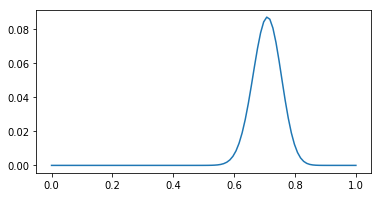

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, 1, n), distrib.pmf(np.arange(0, n)))

It is wide, because there are not that many samples to mesure the error
upon: this is a small dataset.

We can look at the interval in which 95% of the observed accuracy lies
for different sample sizes



In [7]:
for n in [100, 1000, 10000, 100000, 1000000]:
    distrib = stats.binom(n, .7)
    interval = (distrib.isf(.025) - distrib.isf(.975)) / n
    print("Size: {0: 8}  | interval: {1}%".format(n, 100 * interval))

Size:      100  | interval: 18.0%
Size:     1000  | interval: 5.7%
Size:    10000  | interval: 1.8%
Size:   100000  | interval: 0.568%
Size:  1000000  | interval: 0.1796%


In [13]:
from sklearn import model_selection
cv = model_selection.ShuffleSplit(n_splits=300)
scores = cross_val_score(classifier, data, target,
                         cv=cv)
print(scores)

[ 0.68  0.88  0.68  0.76  0.74  0.7   0.66  0.7   0.62  0.6   0.78  0.76
  0.78  0.78  0.76  0.78  0.7   0.6   0.7   0.74  0.7   0.64  0.6   0.62
  0.76  0.7   0.56  0.74  0.66  0.72  0.7   0.7   0.62  0.68  0.56  0.58
  0.66  0.74  0.66  0.66  0.58  0.7   0.66  0.64  0.76  0.66  0.62  0.6
  0.74  0.6   0.74  0.7   0.6   0.72  0.78  0.8   0.74  0.66  0.66  0.82
  0.82  0.72  0.68  0.8   0.82  0.68  0.66  0.68  0.82  0.72  0.68  0.76
  0.64  0.66  0.58  0.76  0.7   0.72  0.7   0.72  0.68  0.64  0.72  0.78
  0.66  0.56  0.76  0.6   0.74  0.64  0.64  0.62  0.72  0.66  0.76  0.64
  0.74  0.74  0.84  0.72  0.64  0.78  0.72  0.72  0.66  0.6   0.62  0.66
  0.74  0.68  0.66  0.64  0.68  0.68  0.66  0.76  0.66  0.74  0.7   0.7
  0.6   0.72  0.6   0.62  0.54  0.66  0.74  0.74  0.7   0.74  0.78  0.74
  0.66  0.74  0.7   0.64  0.66  0.76  0.74  0.76  0.7   0.74  0.66  0.76
  0.58  0.68  0.58  0.76  0.72  0.62  0.68  0.72  0.64  0.56  0.76  0.68
  0.74  0.64  0.7   0.7   0.62  0.78  0.66  0.66  0.4

(array([  1.,   3.,  12.,  32.,  64.,  67.,  68.,  38.,  12.,   3.]),
 array([ 0.46 ,  0.502,  0.544,  0.586,  0.628,  0.67 ,  0.712,  0.754,
         0.796,  0.838,  0.88 ]),
 <a list of 10 Patch objects>)

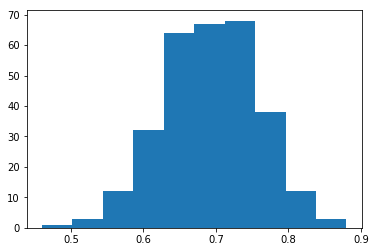

In [15]:
plt.hist(scores)

At 100 000 samples, 5% of the observed classification accuracy still
fall more than .5% away of the true rate.

**Keep in mind that cross-val is a noisy measure**

Importantly, the variance across folds is not a good measure of this
error, as the different data folds are not independent. For instance,
doing many random splits will can reduce the variance arbitrarily, but
does not provide actually new data points



Measuring baselines and chance
-------------------------------

Because of class imbalances, or confounding effects, it is easy to get
it wrong it terms of what constitutes chances. There are two approaches
to measure peformances of baselines or chance:

Let's go back to simple generated data:



In [ ]:
data, target = datasets.make_blobs(centers=[(0, 0), (0, 1)])

**DummyClassifier** The dummy classifier:
:class:`sklearn.dummy.DummyClassifier`, with different strategies to
provide simple baselines



In [ ]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="stratified")
print(cross_val_score(dummy, data, target))

**Chance level** To measure actual chance, the most robust approach is
to use permutations:
:func:`sklearn.model_selection.permutation_test_score`, which is used
as cross_val_score



In [ ]:
from sklearn.model_selection import permutation_test_score
score, permuted_scores, p_value = permutation_test_score(classifier, data, target)
print("Classifier score: {0},\np value: {1}\nPermutation scores {2}"
        .format(score, p_value, permuted_scores))

Cross-validation with non iid data
-----------------------------------

Stock market: time series
...........................

Download and load the data
~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [ ]:
import pandas as pd
import os
# Python 2 vs Python 3:
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

symbols = {'TOT': 'Total', 'XOM': 'Exxon', 'CVX': 'Chevron',
           'COP': 'ConocoPhillips', 'VLO': 'Valero Energy'}

quotes = pd.DataFrame()

for symbol, name in symbols.items():
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    filename = "{}.csv".format(symbol)
    if not os.path.exists(filename):
        urlretrieve(url.format(symbol), filename)
    this_quote = pd.read_csv(filename)
    quotes[name] = this_quote['open']

Predict 'Chevron' from the others



In [ ]:
from sklearn import linear_model, model_selection, ensemble
cv = model_selection.ShuffleSplit(random_state=0)
print(cross_val_score(linear_model.RidgeCV(),
                      quotes.drop(columns=['Chevron']),
                      quotes['Chevron'],
                      cv=cv).mean())

Is this a robust prediction?

Does it cary over across quarters?



In [ ]:
quarters = pd.to_datetime(this_quote['date']).dt.to_period('Q')
cv = model_selection.LeaveOneGroupOut()

print(cross_val_score(linear_model.RidgeCV(),
                      quotes.drop(columns=['Chevron']),
                      quotes['Chevron'],
                      cv=cv, groups=quarters).mean())

The problem that we are facing here is the auto-correlation in the
data: these datasets are **time-series**.



In [ ]:
quotes_with_dates = pd.concat((quotes, this_quote['date']),
                              axis=1).set_index('date')
quotes_with_dates.plot()

If the goal is to do forecasting, than prediction should be done in the
future, for instance using
:class:`sklearn.model_selection.TimeSeriesSplit`

Can we do forecasting: predict the future?



In [ ]:
cv = model_selection.TimeSeriesSplit(n_splits=quarters.nunique())

print(cross_val_score(linear_model.RidgeCV(),
                      quotes.drop(columns=['Chevron']),
                      quotes['Chevron'],
                      cv=cv, groups=quarters).mean())

No. This prediction is abysmal



School grades: repeated measures
.................................

Let us look at another dependency structure across samples: repeated
measures. This is often often in longitudinal data. Here we are looking
at grades of school students, across the years.

Download and load the data
~~~~~~~~~~~~~~~~~~~~~~~~~~~

Download some data on grades across several schools (centers)

The junior school data, originally from http://www.bristol.ac.uk/cmm/learning/support/datasets/



In [ ]:
if not os.path.exists('exams.csv.gz'):
    # Download the file if it is not present
    urlretrieve('https://raw.githubusercontent.com/GaelVaroquaux/interpreting_ml_tuto/blob/master/src/01_how_well/exams.csv.gz',
                filename)
exams = pd.read_csv('exams.csv.gz')

# Select data for students present all three years
continuing_students = exams.StudentID.value_counts()
continuing_students = continuing_students[continuing_students > 2].index
exams = exams[exams.StudentID.isin(continuing_students)]

Visualized factor of grades
~~~~~~~~~~~~~~~~~~~~~~~~~~~

Grade at tests in in exams depend on socio-economic status, year at
school, ...



In [ ]:
import seaborn as sns
g = sns.PairGrid(exams.drop(columns=['StudentID']),
                 diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, s=2)
g.map_diag(sns.kdeplot, lw=3)

Predicting grades in maths
~~~~~~~~~~~~~~~~~~~~~~~~~~~

Can we predict test grades in maths from demographics (ie, not from
other grades)?



In [ ]:
# A bit of feature engineering to get a numerical matrix (easily done
# with the ColumnTransformer in scikit-learn >= 0.20)
X = exams.drop(columns=['StudentID', 'Maths', 'Ravens', 'English'])
# Encode gender as an integer variables
X['Gender'] = X['Gender'] == 'Girl'
# One-hot encode social class
X = pd.get_dummies(X, drop_first=True)
y = exams['Maths']

from sklearn import ensemble
print(cross_val_score(ensemble.GradientBoostingRegressor(), X, y,
                      cv=10).mean())

We get can predict!

But there is one caveat: are we simply learning to recognive students
across the years? There is many implicit informations about students:
notably in the school ID and the class ID.

To test for this, we can make sure that we have different students in
the train and the test set



In [ ]:
from sklearn import model_selection
cv = model_selection.GroupKFold(10)

print(cross_val_score(ensemble.GradientBoostingRegressor(), X, y,
                      cv=cv, groups=exams['StudentID']).mean())

It works better!

The classifier learns better to generalize, probably by learning
stronger invariances from the repeated measures on the students

Summary
.......

Samples often have a dependency structure, such a with time-series, or
with repeated measures. To have a meaningful measure of prediction
error, the link between the train and the test set must match the
important one for the application. In time-series prediction, it must
be in the future. To learn a predictor of the success of an individual
from demographics, it might be more relevant to predict across
individuals. If the variance across individuals is much larger than the
variance across repeated measurement, as in many biomedical
applications, the choice of cross-validation strategy may make a huge
difference.

